# Pine Labs

In [31]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
import gensim
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/pine_labs/pine_labs.csv')

In [4]:
# Company username
company_username = 'PineLabs'

In [5]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [6]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [7]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [8]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [10]:
qdf.shape

(511, 28)

In [11]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 468


In [12]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [13]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [14]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [15]:
result

,conversation_id,response_time
0,1342432402510143490,0.496667
1,1343827514469191681,0.000000
2,1343806828421861377,0.600833
3,1343814255330541571,0.102222
4,1343472138779443202,0.000000
...,...,...
463,1084764264265437184,2.525556
464,1084103141589565440,0.000000
465,1080406875424911360,0.000000
466,1082519608081436672,6.013889


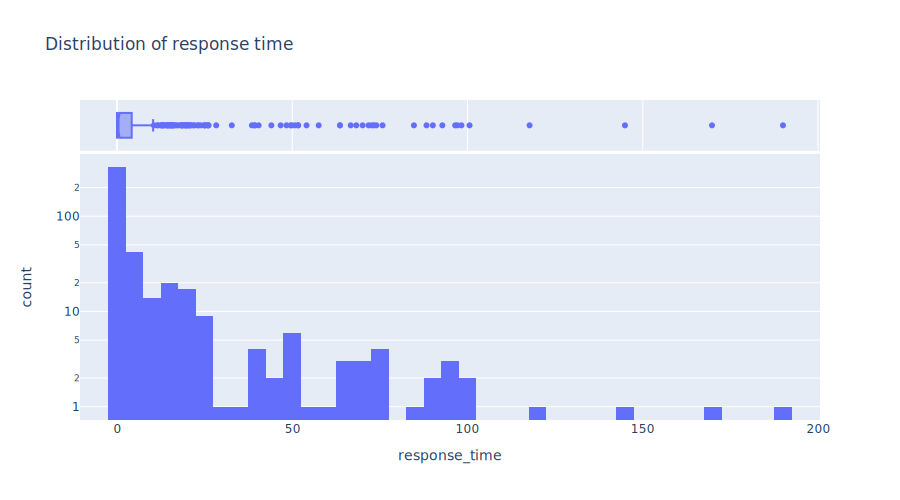

In [18]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [19]:
result['resolution_time'] = 0

In [20]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [21]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 288
Number of queries unresolved: 180


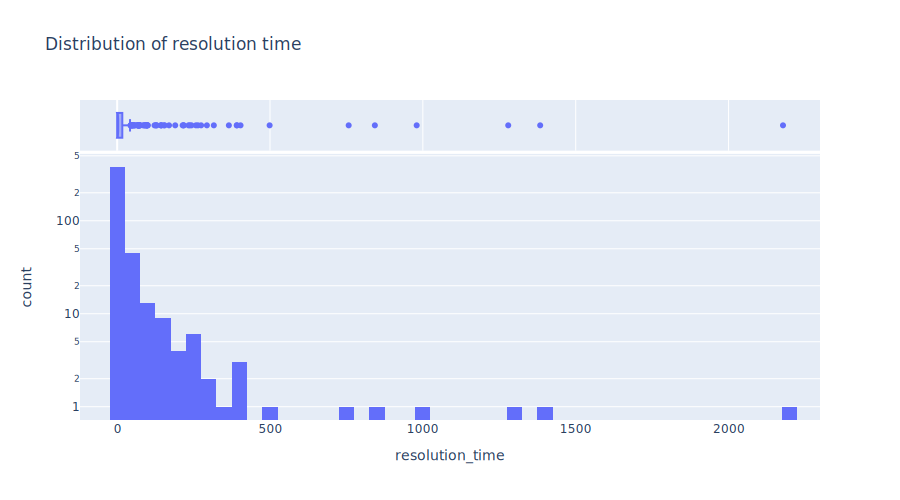

In [25]:
fig = px.histogram(result[result['resolution_time']<3000], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [26]:
result.describe()

,response_time,resolution_time
count,468.000000,468.000000
mean,11.482594,64.629625
std,62.884684,573.200856
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.442778,0.754444
75%,4.286528,17.082917
max,1279.305278,11950.471389


## Query Tweets Topics


In [37]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape

(299, 28)

In [38]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [39]:
pre_queries.shape

(73, 31)

In [40]:
post_queries.shape


(209, 31)

In [43]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.6,
                                        eta=0.3)
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)

Pre-COVID coherence Score:  -12.722334284060025


In [44]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.064744  0.064334       1        1  42.038924
0     -0.094239  0.018327       2        1  36.857870
1      0.029496 -0.082660       3        1  21.103206, topic_info=         Term       Freq      Total Category  logprob  loglift
14   response   8.000000   8.000000  Default  30.0000  30.0000
89    getting   4.000000   4.000000  Default  29.0000  29.0000
199    faulty   2.000000   2.000000  Default  28.0000  28.0000
198    doesnt   2.000000   2.000000  Default  27.0000  27.0000
46        pos  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
443      poor   1.370039   3.807875   Topic3  -4.9932   0.5335
9     machine   3.216952  24.142434   Topic3  -4.1396  -0.4598
311     debit   0.893036   1.815526   Topic3  -5.4212   0.8462
72   customer   1.335372  10.045813   Topic3  -5.0188  -0.4622
279      work   0.810886   2.526766   Topic3  -5.5177   0.4192

[195 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
23        1  0.410688     able
23        3  0.410688     able
101       1  0.448055  account
101       3  0.448055  account
146       1  0.598166      ago
...     ...       ...      ...
279       3  0.395763     work
54        1  0.497098  working
54        2  0.497098  working
55        1  0.664630    worst
55        2  0.265852    worst

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [45]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())

In [46]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['machine, response, pos, service, customer, swipe, pinelab, shame, machines, ct_ct',
       'payment, machine, service, machines, getting, pos, know, help, faulty, month',
       'machine, customer, worst, company, need, help, service, services, month, payment'],
      dtype=object)

Following topics were discussed pre-COVID:
1. POS machine not working as expected
2. No follows
3. Issues related to payments

In [57]:
select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

array(["@PineLabs worst service ever in finance sector. From the day of its installation, it's pos machine is not working properly and tired of calling your peoples in Jharkhand. Business is suffering a lot and I become stupid by paying advance rental. https://t.co/4ZnJGVQS0V",
       '@PineLabs applied for swiping machine and it was promised to get on 17th, but now your team is requesting for one more week. Can u pl help to expedite this?',
       '@EOWDelhi @PunePolice Dear authorities we have informed Pine Labs Private Limited to discontinue services and stop use of ECS mandate to our account. How can we file FIR in this regard. @PineLabs is not responding. Pls guide. #pinelabs',
       '@PineLabs i m from tunmarg aircon Indore(M P) my swipe machine is not working from last three month ur sumeet makwana 📱9907650650 know that but no one give resolution &amp; rental deduct every month why ?\nJust take machine &amp; give my payment back \nCall back ASAP\n9827788674\n9036699339',
      

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



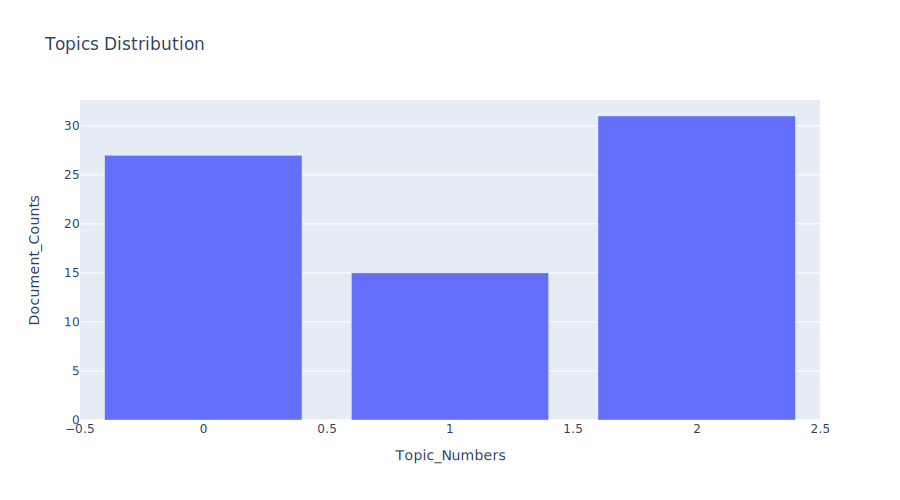

In [51]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()

In [63]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)

Post-COVID coherence Score:  -8.936753749935182


In [64]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.003862  0.087323       1        1  26.941583
2     -0.087093  0.012324       2        1  24.505464
3     -0.013196 -0.094367       3        1  24.286656
0      0.096427 -0.005280       4        1  24.266298, topic_info=            Term       Freq      Total Category  logprob  loglift
234         bank  11.000000  11.000000  Default  30.0000  30.0000
21          card  12.000000  12.000000  Default  29.0000  29.0000
144         dont  12.000000  12.000000  Default  28.0000  28.0000
51        refund   7.000000   7.000000  Default  27.0000  27.0000
330  transaction  15.000000  15.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
42           use   2.961519   6.495834   Topic4  -5.3937   0.6306
29         worst   3.766153  18.096720   Topic4  -5.1533  -0.1536
193      account   3.635045  16.670756   Topic4  -5.1887  -0.1070
33       machine   3.526217  36.888880   Topic4  -5.2191  -0.9316
34        months   3.050824  17.384609   Topic4  -5.3639  -0.3241

[266 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
18        1  0.516302     able
18        3  0.172101     able
18        4  0.344202     able
193       1  0.419897  account
193       2  0.179956  account
...     ...       ...      ...
13        4  0.396712  working
29        1  0.386810    worst
29        2  0.221035    worst
29        3  0.221035    worst
29        4  0.221035    worst

[381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [65]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())

In [66]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['service, days, dont, payment, transaction, customer, working, received, business, trying',
       'machine, card, payment, ur, customer, sales, service, time, pos, charges',
       'machine, team, bank, service, days, received, months, account, worst, issue',
       'service, team, machine, refund, response, days, support, payment, months, th'],
      dtype=object)

Following topics were discussed post pandemic:
1. Poor functioning of POS
2. Settlement/refund issues and POS charges
3. Issues related to accounts
4. No action issues

In [71]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[3]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



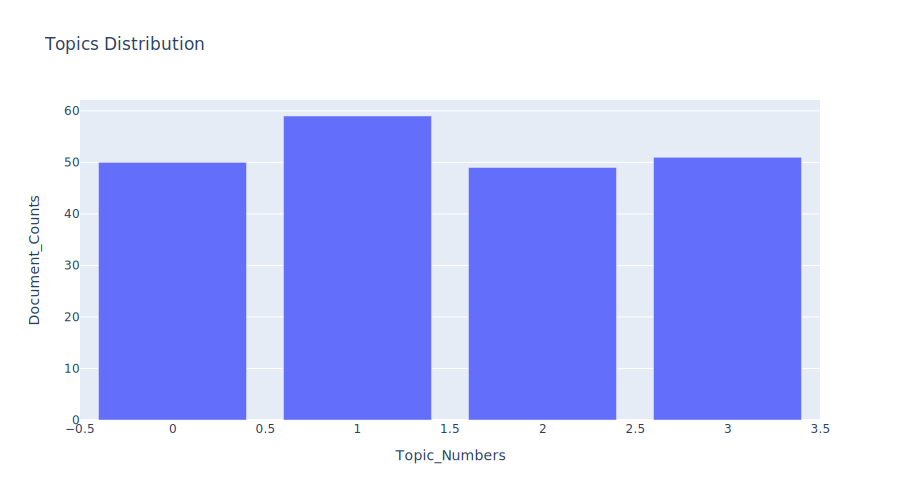

In [72]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()